## **Installing Required Libraries**

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras import layers
from tensorflow.keras import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## **Data Wrangling and Exploration**

In [57]:
df = pd.read_csv('yahoo_stock.csv')
print('columns: ',df.columns)
print('\nFirst 5 rows: ', df.head())
print('\nDataset Shape: ', df.shape)


columns:  Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

First 5 rows:           Date         High          Low         Open        Close  \
0  2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1  2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2  2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3  2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4  2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  

Dataset Shape:  (1825, 7)


- This dataset has 1825 rows and 7 coulmns.
- Columns of dataset are: Date, High, Low, Open, Close, Adj Close

In [58]:
df.corr()

<ipython-input-58-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.998154,0.999328,0.998958,0.084212,0.998958
Low,0.998154,1.000000,0.998794,0.999020,0.044557,0.999020
Open,0.999328,0.998794,1.000000,0.998344,0.069729,0.998344
Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000
Volume,0.084212,0.044557,0.069729,0.063401,1.000000,0.063401
Adj Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000


Volume column has very less correlation with all other columns. So, dropping this column won't affect the result.

In [59]:
# Dropping Volume Column
df = df.drop('Volume', axis=1)

df = df.sort_values('Date')
df = df.set_index('Date')
df.head()

,High,Low,Open,Close,Adj Close
Date,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,2090.110107


In [60]:
print('Missing Values:', df.isna().sum())
print('\nOutliers:', df.skew())

Missing Values: High         0
Low          0
Open         0
Close        0
Adj Close    0
dtype: int64

Outliers: High         0.086096
Low          0.077569
Open         0.085115
Close        0.081869
Adj Close    0.081869
dtype: float64


- Dataset has no missing values.
- Skewness of this dataset is very close to 0, thus has no outliers.

Text(0, 0.5, 'Adjusted Close')

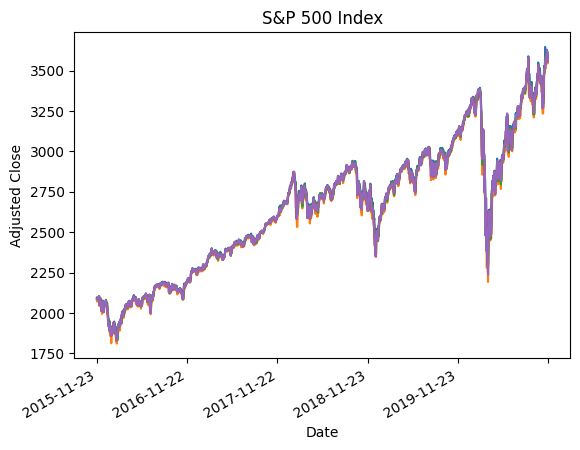

In [61]:
# Plot the data
plt.plot(df)

# Add title and axis labels
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')

## **Data Preprocessing**

In [62]:
train_size = int(len(df)*0.50)
validation_size = int(len(df)*0.25)

# Split into train, validation, and test sets
train_size = int(len(df) * 0.5)
validation_size = int(len(df) * 0.25)
train_df = df.iloc[0:train_size, :]
validation_df = df.iloc[train_size:train_size + validation_size, :]
test_df = df.iloc[train_size + validation_size:len(df), :]


In [65]:
scaler = MinMaxScaler()

scaler.fit(train_df)

train = pd.DataFrame(scaler.transform(train_df), columns=['High', 'Low', 'Open', 'Close', 'Adj Close'], index=train_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns=['High', 'Low', 'Open', 'Close', 'Adj Close'], index=test_df.index)
validation = pd.DataFrame(scaler.transform(validation_df), columns=['High', 'Low', 'Open', 'Close', 'Adj Close'], index=validation_df.index)

In [66]:
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(i + window_size), 0]
        target = dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

window_size = 10

X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## **Building SimpleRNN Model**

In [67]:
model = Sequential()
model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
model.fit(X_train, y_train)

validation_pred = model.predict(X_validation)

print('Model Accuracy: ', r2_score(y_validation, validation_pred))

14/14 [==============================] - 0s 2ms/step
Model Accuracy:  -33.31111574805484


## **LSTM Model**

In [69]:
model = Sequential()
model.add(layers.LSTM(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train)
validation_pred_LSTM = model.predict(X_validation)

print('Accuracy on LSTM Model', r2_score(y_validation, validation_pred_LSTM))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
14/14 [==============================] - 0s 3ms/step
Accuracy on LSTM Model -32.14149538246691


## **Added Convolutional Layer**

In [70]:
model = Sequential()
model.add(layers.Conv1D(64, 1, activation='relu', input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(layers.LSTM(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train)
validation_pred_LSTM = model.predict(X_validation)

print('Accuracy on LSTM Model', r2_score(y_validation, validation_pred_LSTM))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 64)             704       
                                                                 
 lstm_9 (LSTM)               (None, 10)                3000      
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3825 (14.94 KB)
Trainable params: 3825 (14.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
14/14 [==============================] - 0s 2ms/step
Accuracy on LSTM Model -12.380473800532327


## **Optimized Recurrent Convolutional Model**

In [76]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(f"\nR-Squared value on validation set: {r2_score(y_validation, y_pred)}")

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 1, 128)            1408      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dense_47 (Dense)            (None, 8)                 136       
                                                     

## **Evaluation of Model**

In [77]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

14/14 [==============================] - 0s 4ms/step
0.9973071905795321  --> Training Set
0.9664378411074154  --> Validation Set
0.9453075708693033  --> Test Set


**We have achieved 94% accuracy in Test Dataset.**